In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
sns.set_style("dark")
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import scale

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender =pd.read_csv("gender_submission.csv")

In [40]:
y_train = train['Survived']

In [63]:
X_train = train.drop(['Survived','PassengerId','Name'],1)

In [66]:
scale(X_train)

ValueError: could not convert string to float: 'Q'

In [76]:
X_train['Sex'] = X_train['Sex'].apply(lambda val: 1 if val =='male'  else 0 )

In [83]:
X_train['Ticket'].unique()

681

(array([ 7.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   0. ,   68.7,  137.4,  206.1,  274.8,  343.5,  412.2,  480.9,
         549.6,  618.3,  687. ]),
 <a list of 10 Patch objects>)

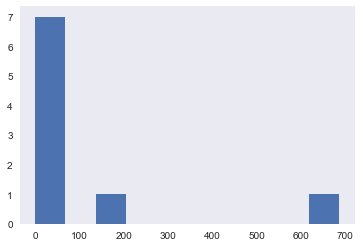

In [106]:
plt.hist(X_train.isnull().sum())

In [99]:
plt.bar(,X_train.isnull().sum())

TypeError: bar() missing 1 required positional argument: 'height'

In [111]:
X_train.isnull().sum().rows

AttributeError: 'Series' object has no attribute 'rows'

In [ ]:
X_train['Embarked']

In [60]:
X_train[X_train.columns[X_train.dtypes == 'int64']]

,PassengerId,Pclass,SibSp,Parch
0,1,3,1,0
1,2,1,1,0
2,3,3,0,0
3,4,1,1,0
4,5,3,0,0
5,6,3,0,0
6,7,1,0,0
7,8,3,3,1
8,9,3,0,2
9,10,2,1,0


# types

In [9]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [24]:
train["SibSp"].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [25]:
test['SibSp'].unique()

array([0, 1, 2, 3, 4, 5, 8], dtype=int64)

In [33]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


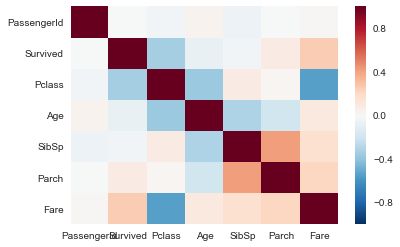

In [38]:
sns.heatmap(train.corr())